In [1]:
from google.colab import drive

drive.mount('/content/drive')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/drive
Sun Aug 11 19:47:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              52W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------

In [6]:
!pip install wandb

In [3]:
from huggingface_hub import login
from google.colab import userdata
import inspect
import wandb

In [5]:
import wandb
wandb.login(key = userdata.get('Wandb_KEY'))
wandb.init(project='Llama3_check_ml')

In [29]:
!ls

 AkashUI.ipynb			        project_architecture.gdoc
 app.ipynb			        QLoRA-Llama-3-8b-chat-finetune-InsuranceQA
 app.py				        quantized_model
 data				        RAJ_Copy_of_app.ipynb
 Final_submission		       'Raj_finetuning (2).ipynb'
 fine_tuned_distilbert_model.pth        results
 htmlTemplates.py		        static
 inference.ipynb		        templates
 Llama-3-8b-chat-finetune-InsuranceQA   test_dataset.csv
 llama.cpp			        train_dataset.csv
 logs				        validation_dataset.csv
 main.py			        vectorstore.index
 model				        venv
 new_base_dir_openinsurancellm	        video
 new_quantized_dir_openinsurancellm     video1640489693.mp4
 Nvidia_Llama-3-8b-chat-finetune        wandb
 offload_dir


In [7]:
cd /content/drive/MyDrive/Chatbot_InsuranceQA

/content/drive/MyDrive/Chatbot_InsuranceQA


In [8]:
!pwd

/content/drive/MyDrive/Chatbot_InsuranceQA


In [9]:
!pip list | grep -E 'transformers|accelerate|torch|tensorflow'

accelerate                       0.32.1
tensorflow                       2.17.0
tensorflow-datasets              4.9.6
tensorflow-hub                   0.16.1
tensorflow-io-gcs-filesystem     0.37.1
tensorflow-metadata              1.15.0
tensorflow-probability           0.24.0
torch                            2.3.1+cu121
torchaudio                       2.3.1+cu121
torchsummary                     1.5.1
torchtext                        0.18.0
torchvision                      0.18.1+cu121
transformers                     4.42.4


In [7]:
!pip install -U bitsandbytes accelerate transformers peft

In [8]:
!pip list | grep -E 'peft|bitsandbytes|accelerate|datasets'

accelerate                       0.33.0
bitsandbytes                     0.43.3
peft                             0.12.0
tensorflow-datasets              4.9.6
vega-datasets                    0.9.0


In [9]:
!pip show peft

Name: peft
Version: 0.12.0
Summary: Parameter-Efficient Fine-Tuning (PEFT)
Home-page: https://github.com/huggingface/peft
Author: The HuggingFace team
Author-email: sourab@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: accelerate, huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch, tqdm, transformers
Required-by: 


# Import Libraries

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    TrainerCallback,
    logging,
    EarlyStoppingCallback,
    pipeline,
)
from peft import LoraConfig, PeftModel, get_peft_model
from datasets import load_dataset as hf_load_dataset, Dataset
from trl import SFTTrainer
import re
import warnings
import bitsandbytes
from peft import prepare_model_for_kbit_training
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# Define custom dataset loading function for QA format
def load_custom_text_dataset(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    if not lines:
        raise ValueError(f"Empty data file: {file_path}")

    data = []
    current_context = None
    current_qa = {"text": ""}
    system_message = ("System: This is a chat between a user and an artificial intelligence assistant. "
                      "The assistant gives helpful, detailed, and polite answers to the user's questions based on the context. "
                      "The assistant should also indicate when the answer cannot be found in the context.")

    for line in lines:
        if line.startswith("[CONTEXT]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_context = line.replace("[CONTEXT]", "").strip()
        elif line.startswith("[Q]"):
            if current_qa["text"]:  # save previous QA
                data.append(current_qa)
                current_qa = {"text": ""}
            current_qa["text"] = (f"{system_message}\n\n{current_context}\n\nUser: {line.replace('[Q]', '').strip()}\n\nAssistant:")
        elif line.startswith("[A]"):
            current_qa["text"] += f" {line.replace('[A]', '').strip()}"
        else:
            current_qa["text"] += f" {line.strip()}"

    if current_qa["text"]:
        data.append(current_qa)

    if not data:
        raise ValueError("No data loaded from the file.")

    return Dataset.from_list(data)

# Read Data with Format

In [ ]:
train_file_path = "data/sample/train_1250_sample_QA.txt"
valid_file_path = "data/sample/sample_valid.txt"
test_file_path = "data/sample/sample_test.txt"

# Load datasets
train_dataset = load_custom_text_dataset(train_file_path)
valid_dataset = load_custom_text_dataset(valid_file_path)
test_dataset = load_custom_text_dataset(test_file_path)

# Model Training

In [ ]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training

# Set environment variable for memory management
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'

# Model and output configuration
model_name = "nvidia/LLama3-ChatQA-1.5-8B"  # Placeholder model name; replace with actual model name if different
output_dir = 'model/QLoRA_Nvidia_LLaMA_3_Sample'
new_model = "QLoRA-Llama-3-8b-chat-finetune-InsuranceQA"

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Configure 8-bit quantization for faster loading
""" Can also used 4 bit quantization for faster execution """

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf8",
    bnb_8bit_compute_dtype=torch.float16
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load model with optimized configuration for A100 and explicitly set to GPU
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": torch.cuda.current_device()},
    torch_dtype=torch.float16,
    use_cache=True,
    low_cpu_mem_usage=True
)

# Optionally prepare the model for training
model = prepare_model_for_kbit_training(model)

# Disable gradient checkpointing for faster inference
model.config.use_cache = True

# Print model configuration for verification
print(model.config)

# Save tokenizer and model configuration if needed
tokenizer.save_pretrained(output_dir)
model.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Unused kwargs: ['bnb_8bit_use_double_quant', 'bnb_8bit_quant_type', 'bnb_8bit_compute_dtype']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

LlamaConfig {
  "_name_or_path": "nvidia/LLama3-ChatQA-1.5-8B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": false,
    "_load_in_8bit": true,
    "bnb_4bit_compute_dtype": "float32",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "fp4",
    "bnb_4bit_use_double_quant": false,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": false,
    "load_in_8bit": true,
    "quant_method": "bitsandbytes"
  },
  "rm

In [ ]:
"""
PEFT Config
"""
# Load LoRA configuration
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)

model.config.use_cache = False
model.config.pretraining_tp = 1
model = get_peft_model(model, peft_config)

In [ ]:
"""
For r = 16 -> trainable parameters are 0.9%
For now I am selecting r = 8 (because of resource contraint)
"""
print_trainable_parameters(model)

trainable params: 20971520 || all params: 8051232768 || trainable%: 0.26047588741133265


In [ ]:
print(dir(bitsandbytes.optim))

['Adagrad', 'Adagrad32bit', 'Adagrad8bit', 'Adam', 'Adam32bit', 'Adam8bit', 'AdamW', 'AdamW32bit', 'AdamW8bit', 'GlobalOptimManager', 'LAMB', 'LAMB32bit', 'LAMB8bit', 'LARS', 'LARS32bit', 'LARS8bit', 'Lion', 'Lion32bit', 'Lion8bit', 'PagedAdam', 'PagedAdam32bit', 'PagedAdam8bit', 'PagedAdamW', 'PagedAdamW32bit', 'PagedAdamW8bit', 'PagedLion', 'PagedLion32bit', 'PagedLion8bit', 'PytorchLARS', 'RMSprop', 'RMSprop32bit', 'RMSprop8bit', 'SGD', 'SGD32bit', 'SGD8bit', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'adagrad', 'adam', 'adamw', 'lamb', 'lars', 'lion', 'optimizer', 'rmsprop', 'sgd']


In [ ]:
# TrainingArguments parameters
from bitsandbytes.optim import PagedAdamW8bit
import inspect
# PagedAdamW8bit(model.parameters(), lr=1e-3)
# # Inspect the attributes of PagedAdamW8bit optimizer
attributes = inspect.getsource(PagedAdamW8bit)
# attributes = [a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]
print(attributes)

class PagedAdamW8bit(Optimizer2State):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=1e-2,
        amsgrad=False,
        optim_bits=32,
        args=None,
        min_8bit_size=4096,
        percentile_clipping=100,
        block_wise=True,
    ):
        """
        Paged 8-bit AdamW optimizer.

        Arguments:
            params (`torch.tensor`):
                The input parameters to optimize.
            lr (`float`, defaults to 1e-3):
                The learning rate.
            betas (`tuple(float, float)`, defaults to (0.9, 0.999)):
                The beta values are the decay rates of the first and second-order moment of the optimizer.
            eps (`float`, defaults to 1e-8):
                The epsilon value prevents division by zero in the optimizer.
            weight_decay (`float`, defaults to 1e-2):
                The weight decay value for the optimizer.
            amsgrad

In [ ]:
# TrainingArguments parameters
from bitsandbytes.optim import PagedAdamW8bit
custom_optimizer = PagedAdamW8bit(
    model.parameters(),
    lr=5e-4,  # test to avoid overshooting optimal point
    betas=(0.9, 0.98),  # Slightly adjusted betas for better stability
    amsgrad=True,  # Enable AMSGrad for more robust optimization
    block_wise=True
)

num_train_epochs = 6
per_device_train_batch_size = 2
save_steps = 100

In [ ]:
custom_optimizer

PagedAdamW8bit (
Parameter Group 0
    betas: (0.9, 0.98)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.01
)

In [ ]:
# Seting training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    save_steps=save_steps,
    fp16=True,  # Enable mixed precision
    save_strategy='epoch',
    metric_for_best_model='eval_loss',
    logging_steps=50,  # Reduce logging frequency to avoid overhead
    gradient_accumulation_steps=4,  # Reduce gradient accumulation steps to lower memory usage
    gradient_checkpointing=True,
    learning_rate=3e-4,  # Increased learning rate for faster convergence
    lr_scheduler_type='reduce_lr_on_plateau',  # Change scheduler for faster learning rate decay
    warmup_steps=2,
    max_grad_norm=1.0,
    #max_step = 100,
    evaluation_strategy='epoch',
    eval_steps=50,  # Reduce evaluation frequency
    weight_decay=0.01,
    adam_epsilon=1e-8,
    load_best_model_at_end=True
)

# Defining custom callback
class EvaluateValidationSetCallback(TrainerCallback):
    """Custom callback for evaluating the validation set every 5 epochs."""
    def __init__(self, valid_dataset):
        self.valid_dataset = valid_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        if (state.epoch + 1) % 5 == 0: # For more frequent val evaluation reduce 5 to 2
            print(f"Evaluating validation set at epoch {state.epoch}")
            val_results = self.trainer.evaluate(eval_dataset=self.valid_dataset)
            val_loss = val_results["eval_loss"]
            perplexity = torch.exp(torch.tensor(val_loss)).item()
            print(f"\tValidation Set Loss: {val_loss:.6f}")
            print(f"\tValidation Set Perplexity: {perplexity:.2f}\n")

# Seting supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    optimizers = (custom_optimizer, None),
    eval_dataset=valid_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=[EvaluateValidationSetCallback(valid_dataset), EarlyStoppingCallback(early_stopping_patience=4)],
    packing=False,
)

# Adding reference to the trainer in the callback
for callback in trainer.callback_handler.callbacks:
    if isinstance(callback, EvaluateValidationSetCallback):
        callback.trainer = trainer

# # For T4 -> GPU
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Set environment variable for memory management -> A100
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

# Evaluate on test set
print("Evaluating on the test set...")
test_results = trainer.evaluate(eval_dataset=test_dataset)
test_loss = test_results["eval_loss"]
perplexity = torch.exp(torch.tensor(test_loss)).item()
print(f"Test Set Loss: {test_loss:.6f}")
print(f"Test Set Perplexity: {perplexity:.2f}\n")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub

Epoch,Training Loss,Validation Loss
0,1.025500,1.010114
1,0.814300,0.579039
2,0.509700,0.430903
4,0.294500,0.366401
5,0.264900,0.352962


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Evaluating validation set at epoch 4.0
	Validation Set Loss: 0.382514
	Validation Set Perplexity: 1.47



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

Evaluating on the test set...


Test Set Loss: 0.349440
Test Set Perplexity: 1.42



# Merging Base Model with Finetuned LoRa adapters/weights

In [ ]:
!ls model/QLoRA_Nvidia_LLaMA_3_Sample/

checkpoint-10	checkpoint-936			  model.safetensors.index.json
checkpoint-156	config.json			  quantized_model
checkpoint-312	generation_config.json		  runs
checkpoint-468	model-00001-of-00003.safetensors  special_tokens_map.json
checkpoint-625	model-00002-of-00003.safetensors  tokenizer_config.json
checkpoint-781	model-00003-of-00003.safetensors  tokenizer.json


In [ ]:
!ls model/QLoRA_Nvidia_LLaMA_3_Sample/checkpoint-936

adapter_config.json	   README.md	  special_tokens_map.json  trainer_state.json
adapter_model.safetensors  rng_state.pth  tokenizer_config.json    training_args.bin
optimizer.pt		   scheduler.pt   tokenizer.json


In [ ]:
from huggingface_hub import login
login()

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Paths
base_model = "nvidia/LLama3-ChatQA-1.5-8B"  # Hugging Face Model ID
lora_dir = 'model/QLoRA_Nvidia_LLaMA_3_Sample/checkpoint-936'
output_dir = '/content/drive/MyDrive/model/new_merged_model/'
os.makedirs(output_dir, exist_ok=True)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token if not already set
tokenizer.padding_side = "right"
tokenizer.save_pretrained(output_dir)

# Load LoRA config
lora_config = LoraConfig.from_pretrained(lora_dir)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    device_map={"": torch.cuda.current_device()},  # Explicit GPU assignment
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    trust_remote_code=True
)

# Apply LoRA and merge
model = get_peft_model(model, lora_config)
model = model.merge_and_unload()

# Save the merged model
model.save_pretrained(output_dir)
print(f"Merged model and tokenizer saved to {output_dir}")

# Set model to evaluation mode
model.eval()

tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

Merged model and tokenizer saved to /content/drive/MyDrive/model/new_merged_model/


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [ ]:
!git lfs install

Git LFS initialized.


# Push the Model to Hugging Face

In [ ]:
model.push_to_hub("OpenInsuranceLLM-Llama3-8B")

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Raj402/OpenInsuranceLLM-Llama3-8B/commit/e4c448119f61a913a02c4877fde527002639996e', commit_message='Upload LlamaForCausalLM', commit_description='', oid='e4c448119f61a913a02c4877fde527002639996e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("OpenInsuranceLLM-Llama3-8B")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Raj402/OpenInsuranceLLM-Llama3-8B/commit/dc54ac62287013ab0f4364be7cd00740524b534a', commit_message='Upload tokenizer', commit_description='', oid='dc54ac62287013ab0f4364be7cd00740524b534a', pr_url=None, pr_revision=None, pr_num=None)

# Inference of Merged Model

In [1]:
from textwrap import dedent
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [14]:
output_dir = '/content/drive/MyDrive/model/new_merged_model/'

# Paths
finetuned_model = "/content/drive/MyDrive/model/new_merged_model/"  # Hugging Face Model ID
lora_dir = 'model/QLoRA_Nvidia_LLaMA_3_Sample/checkpoint-936'

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(finetuned_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token if not already set
tokenizer.padding_side = "right"
tokenizer.save_pretrained(output_dir)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    finetuned_model,
    device_map={"": torch.cuda.current_device()},  # Explicit GPU assignment
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    trust_remote_code=True
)

# Set model to evaluation mode
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [24]:
%%time
# Main loop for user input
model.config.use_cache = True

# Define the system message
system_message = """You are an expert and experienced from the Insurance domain with extensive insurance knowledge and professional writter with all the insurance policies.
    Your name is OpenInsuranceLLM, and you were developed by Raj Maharajwala. who's willing to help answer the user's query with explanation.
    In your explanation, leverage your deep insurance expertise such as relevant insurance policies, complex coverage plans, or other pertinent insurance concepts.
    Use precise insurance terminology while still aiming to make the explanation clear and accessible to a general audience."""

# Main loop for user input
context = ""
max_seq_len = 256
print("Welcome to Insurance-Llama3 ChatBot:\n\nEnter your question (or type 'exit' to quit)\n\n")
while True:
    user_input = input("Raj: ").strip()
    if user_input.lower() == "exit":
        break

    if context == "":
        context_input = input("Enter context (or press Enter to skip): ").strip()
        context = context_input if context_input else "No context provided."

    # Tokenize input
    input_text = f"{system_message}\n\n{context}\n\nInsurance Question: {user_input}\n\nInsurance Answer:"
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)["input_ids"]

    # Generate response
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids.to(model.device),
            max_length=max_seq_len,
            num_return_sequences=1,
            temperature=0.0,
            top_k=10,
            top_p=0.5,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode response
    response = tokenizer.decode(outputs[0], skip_special_tokens=True).split("Insurance Answer:")[-1].strip()
    print(f"Assistant: {dedent(response)}\n")

Welcome to Insurance-Llama3 ChatBot:

Enter your question (or type 'exit' to quit)


Raj: At what age does one become eligible for Medicare?
Enter context (or press Enter to skip): 
Assistant: You become eligible for Medicare at the age of 65.

Raj: How much is ultrasound without health insurance?
Assistant: Sorry. I cannot find the answer based on the context.

Raj: Does Medicare cover eye refraction tests?
Assistant: Yes, Medicare Part B covers eye refraction tests once every 12 months.

Raj: Does AARP Have Long Term Care Insurance ?
Assistant: Yes, AARP offers long-term care insurance policies through a partnership with New York Life Insurance Company. These policies can help cover the costs of long-term care services, such as in-home care or nursing home care, for individuals who are unable to perform daily activities due to a chronic illness or disability.

Raj: Is it possible to get life insurance with diabetes?
Assistant: php

Yes, it is possible to get life insurance with diabe

# Optimized Inference (for CPU): by Quantization of model into .gguf Format
### 5 bit (Q5_K_M.gguf), and 4 bit (Q4_K_M.gguf)

In [10]:
import locale
def getpreferredencoding(do_setlocale = True):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Setup Llama.cpp and install required packages
!git clone https://github.com/ggerganov/llama.cpp
!cd llama.cpp && LLAMA_CUBLAS=1 make && pip install -r requirements.txt

Cloning into 'llama.cpp'...
remote: Enumerating objects: 31822, done.
remote: Counting objects: 100% (10154/10154), done.
remote: Compressing objects: 100% (665/665), done.
remote: Total 31822 (delta 9877), reused 9514 (delta 9484), pack-reused 21668
Receiving objects: 100% (31822/31822), 55.30 MiB | 16.62 MiB/s, done.
Resolving deltas: 100% (22919/22919), done.
Updating files: 100% (948/948), done.
Makefile:76: *** LLAMA_CUBLAS is removed. Use GGML_CUDA instead..  Stop.


In [ ]:
pwd

'/content/drive/MyDrive/Chatbot_InsuranceQA'

## Downloading my Model from Hugging Face

In [ ]:
from huggingface_hub import snapshot_download
model_name = "Raj402/OpenInsuranceLLM-Llama3-8B"
methods = ['q4_k_m', 'q5_k_m']
finetuned_model = "./new_base_dir_openinsurancellm/"
quantized_path = "./new_quantized_dir_openinsurancellm/"
#
snapshot_download(repo_id=model_name, local_dir=finetuned_model , local_dir_use_symlinks=False)
fp16_file = quantized_path+'FP16.gguf'

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/143 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

In [ ]:
!git lfs install

Git LFS initialized.


In [ ]:
!mkdir {quantized_path}

# Creating FP16 model file from Finetuned model using llama.cpp

In [ ]:
!python llama.cpp/convert_hf_to_gguf.py {finetuned_model} --outtype f16 --outfile {fp16_file}

## Creating 4 bit and 5 bit quantized .gguf files

#### QUANTIZATION_METHODS  =  ["Q4_K_M", "Q5_K_M"]

In [33]:
QUANTIZATION_METHODS = ["q4_k_m", "q5_k_m"]

import os
for m in QUANTIZATION_METHODS:
  qtype = f"{quantized_path}/{m.upper()}.gguf"
  os.system("./llama.cpp/quantize "+quantized_path+"/FP16.gguf "+qtype+" "+m)

In [34]:
!ls 'llama.cpp'
print("\n\n")
!ls '/content/drive/MyDrive/model/new_merged_model/'

AUTHORS		   convert_hf_to_gguf.py	  ggml	    mypy.ini		requirements
build		   convert_hf_to_gguf_update.py   gguf-py   Package.swift	requirements.txt
ci		   convert_llama_ggml_to_gguf.py  grammars  pocs		scripts
cmake		   convert_lora_to_gguf.py	  include   poetry.lock		SECURITY.md
CMakeLists.txt	   docs				  LICENSE   prompts		spm-headers
CMakePresets.json  examples			  Makefile  pyproject.toml	src
common		   flake.lock			  media     pyrightconfig.json	tests
CONTRIBUTING.md    flake.nix			  models    README.md



config.json			  model-00003-of-00004.safetensors  tokenizer_config.json
generation_config.json		  model-00004-of-00004.safetensors  tokenizer.json
model-00001-of-00004.safetensors  model.safetensors.index.json
model-00002-of-00004.safetensors  special_tokens_map.json


In [14]:
!mkdir llama.cpp/build && cd llama.cpp/build && cmake .. && cmake --build . --config Release

In [36]:
quantized_path = '/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm'
q4 = os.path.join(quantized_path, f"openinsurancellm-llama3-8b.{'q4_k_m'.upper()}.gguf")
q5 = os.path.join(quantized_path, f"openinsurancellm-llama3-8b.{'q5_k_m'.upper()}.gguf")
q5

'/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/openinsurancellm-llama3-8b.Q5_K_M.gguf'

In [37]:
fp16_file = '/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/FP16.gguf'

In [38]:
!cd llama.cpp/build/bin && ./llama-quantize {fp16_file} {q5} q5_K_M

main: build = 3565 (6e02327e)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: quantizing '/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/FP16.gguf' to '/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/openinsurancellm-llama3-8b.Q5_K_M.gguf' as Q5_K_M
llama_model_loader: loaded meta data with 27 key-value pairs and 291 tensors from /content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/FP16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = LLama3 ChatQA 1.5 8B
llama_model_loader: - kv   3:                   

In [39]:
!cd llama.cpp/build/bin && ./llama-quantize {fp16_file} {q4} q4_K_M

main: build = 3565 (6e02327e)
main: built with cc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0 for x86_64-linux-gnu
main: quantizing '/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/FP16.gguf' to '/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/openinsurancellm-llama3-8b.Q4_K_M.gguf' as Q4_K_M
llama_model_loader: loaded meta data with 27 key-value pairs and 291 tensors from /content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/FP16.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = LLama3 ChatQA 1.5 8B
llama_model_loader: - kv   3:                   

In [50]:
!ls new_quantized_dir_openinsurancellm

FP16.gguf  openinsurancellm-llama3-8b.Q4_K_M.gguf  openinsurancellm-llama3-8b.Q5_K_M.gguf


In [48]:
from huggingface_hub import login
from google.colab import userdata

login(token = userdata.get("HF_TOKEN"))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [51]:
# import inspect
# print(inspect.getsource(login))

In [52]:
 from huggingface_hub import create_repo, HfApi
from google.colab import userdata

username = "Raj-Maharajwala"
MODEL_NAME = "OpenInsuranceLLM-Llama3-8B"

# Defined in the secrets tab in Google Colab
api = HfApi(token=userdata.get("HF_TOKEN"))

# Create empty repo
create_repo(
    repo_id = f"{username}/{MODEL_NAME}-GGUF",
    repo_type="model",
    exist_ok=True,
)

# Upload gguf files
api.upload_folder(
    folder_path="new_quantized_dir_openinsurancellm",
    repo_id=f"{username}/{MODEL_NAME}-GGUF",
    allow_patterns=f"*.gguf",
)

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

openinsurancellm-llama3-8b.Q4_K_M.gguf:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

FP16.gguf:   0%|          | 0.00/16.1G [00:00<?, ?B/s]

openinsurancellm-llama3-8b.Q5_K_M.gguf:   0%|          | 0.00/5.73G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Raj-Maharajwala/OpenInsuranceLLM-Llama3-8B-GGUF/commit/46b7258b373334adb819b09bc7aa17f861999afe', commit_message='Upload folder using huggingface_hub', commit_description='', oid='46b7258b373334adb819b09bc7aa17f861999afe', pr_url=None, pr_revision=None, pr_num=None)

# Inference Q5_K_M.gguf models using llama_cpp_python (verbose = True)

Note: Inference using .gguf models is extremly fast for CPU because of 5 bit .gguf and llama_cpp_python

In [ ]:
!pip install llama-cpp-python==0.2.85

In [27]:
from llama_cpp import Llama
from textwrap import dedent
import glob
from pathlib import Path
import time
import os

In [ ]:
model_1_path = '/content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/openinsurancellm-llama3-8b.Q5_K_M.gguf'

llm_ctx = Llama(model_path=model_1_path,
                    n_gpu_layers = 0, # Running on CPU
                    n_ctx = 8192,
                    n_threads = 32,
                    n_batch = 512,
                    verbose = True)


start_time = time.time()
# print(f"User: {Question}\n")
simple_prompt = "What is the cost of an ultrasound without health insurance?"

response = llm_ctx(simple_prompt, max_tokens=1000, top_k=10, temperature=0.0)
ntokens = response['usage']['completion_tokens']
ntokens = 1 if ntokens==0 else ntokens
response = response['choices'][0]['text']
response = dedent(response)
execution_time = time.time() - start_time
print(f"Assistant: {response}")
print(f"tokens: {ntokens}")
print(f"Time: {execution_time:.2f} s  Per Token: {(1.0*execution_time/ntokens):.2f} s\n Token/sec: {(1.0*ntokens/execution_time):.2f} Tokens/s\n\n")

llama_model_loader: loaded meta data with 27 key-value pairs and 291 tensors from /content/drive/MyDrive/Chatbot_InsuranceQA/new_quantized_dir_openinsurancellm/openinsurancellm-llama3-8b.Q5_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = LLama3 ChatQA 1.5 8B
llama_model_loader: - kv   3:                       general.organization str              = Nvidia
llama_model_loader: - kv   4:                           general.basename str              = LLama3-ChatQA-1.5
llama_model_loader: - kv   5:                         general.size_label str              = 8B
llama_model_loader: - kv   6:                          llama.bl

Assistant: The cost of an ultrasound without health insurance varies depending on the type of ultrasound and the location where it is performed. Generally, an ultrasound costs between $100 and $500, but prices can vary based on factors such as the type of ultrasound, the location where it is performed, and the experience of the technician performing the ultrasound. It is important to check with your insurance provider to see if they cover any of the costs associated with an ultrasound.
tokens: 89
Time: 23.82 s  Per Token: 0.27 s
 Token/sec: 3.74 Tokens/s




# Inference Loop (Q5_K_M.gguf model) using llama_cpp_python (verbose = False)

In [9]:
cd /content/drive/MyDrive/Chatbot_InsuranceQA

/content/drive/MyDrive/Chatbot_InsuranceQA


In [31]:
import os
import psutil
import time
from pathlib import Path
from llama_cpp import Llama
from textwrap import dedent

def load_model(n_ctx, n_threads, n_batch, n_gpu_layers):
    quantized_path = "new_quantized_dir_openinsurancellm/"
    MODEL_DIR = os.path.join(os.getcwd(), quantized_path)
    directory = Path(MODEL_DIR)
    model_1_path = str(list(directory.glob('openinsurancellm*Q5*.gguf'))[0])

    llm_ctx = Llama(model_path=model_1_path,
                    n_gpu_layers=n_gpu_layers,  # No GPU layers
                    n_ctx=n_ctx,
                    n_threads=n_threads,
                    n_batch=n_batch,
                    verbose=False)
    return llm_ctx


def get_prompt(Question):
    System = """You are an expert and experienced from the Insurance domain with extensive insurance knowledge and professional writter with all the insurance policies.
    Your name is OpenInsuranceLLM, and you were developed by Raj Maharajwala. who's willing to help answer the user's query with explanation.
    In your explanation, leverage your deep insurance expertise such as relevant insurance policies, complex coverage plans, or other pertinent insurance concepts.
    Use precise insurance terminology while still aiming to make the explanation clear and accessible to a general audience."""

    prompt = f"system\n{System}\nuser\Insurance Question: {Question}\nassistant\nInsurance Answer: "
    return prompt


def inference_loop(max_tokens=8025, top_k=15, n_gpu_layers=0, temperature=0.0, n_ctx=8192, n_threads=32, n_batch=512):
    # Load the model
    print("Welcome to OpenInsuranceLLM Inference Loop:\n\n")

    llm_ctx = load_model(n_ctx, n_threads, n_batch, n_gpu_layers)
    print(f"OpenInsuranceLLM Q5_K_M model loaded successfully with n_batch={n_batch}!\n\nEnter your question (or type 'exit' to quit)\n")

    while True:
        Question = input("Raj: ").strip()
        if Question.lower() == "exit":
            print("Assistant: Good Bye!")
            break

        prompt = get_prompt(Question)

        start_time = time.time()
        response = llm_ctx(prompt, max_tokens=max_tokens, top_k=top_k, temperature=temperature)
        ntokens = response['usage']['completion_tokens']
        ntokens = 1 if ntokens == 0 else ntokens
        response = response['choices'][0]['text']
        response = dedent(response)
        execution_time = time.time() - start_time
        print(f"Assistant: {response}")
        print(f"tokens: {ntokens}")
        print(f"Time: {execution_time:.2f} s  Per Token: {(1.0 * execution_time / ntokens):.2f} s\n\n\n")

In [33]:
#default params: inference_loop(max_tokens=8025, top_k=15, n_gpu_layers=0, temperature=0.0, n_ctx=8192, n_threads=32, n_batch=512):
inference_loop(top_k=10)

Welcome to OpenInsuranceLLM Inference Loop:


OpenInsuranceLLM Q5_K_M model loaded successfully with n_batch=1024!

Enter your question (or type 'exit' to quit)

Raj: At what age does one become eligible for Medicare?
Assistant: 65 years old
tokens: 3
Time: 10.94 s  Per Token: 3.65 s



Raj: Does Medicare cover eye refraction tests?
Assistant: Yes, Medicare Part B covers eye refraction tests.
tokens: 12
Time: 2.95 s  Per Token: 0.25 s



Raj: How much is ultrasound without health insurance?
Assistant: As an AI language model, I do not have access to current pricing information. However, ultrasounds are typically covered by health insurance, so you may want to check with your insurance provider to determine your out-of-pocket costs.
tokens: 47
Time: 8.73 s  Per Token: 0.19 s



Raj: Does Walmart accept Medicare?
Assistant: Yes, Walmart accepts Medicare.
tokens: 7
Time: 1.98 s  Per Token: 0.28 s



Raj: Is Disability Insurance Legally Required?
Assistant: php
No, disability insurance is 

# Context Specification using RAG (Retrieval-Augmented Generation)

- Earlier we haven't specify the context to the prompt.
- Text Generation can become more efficient and faster if we specify the context using RAG approach

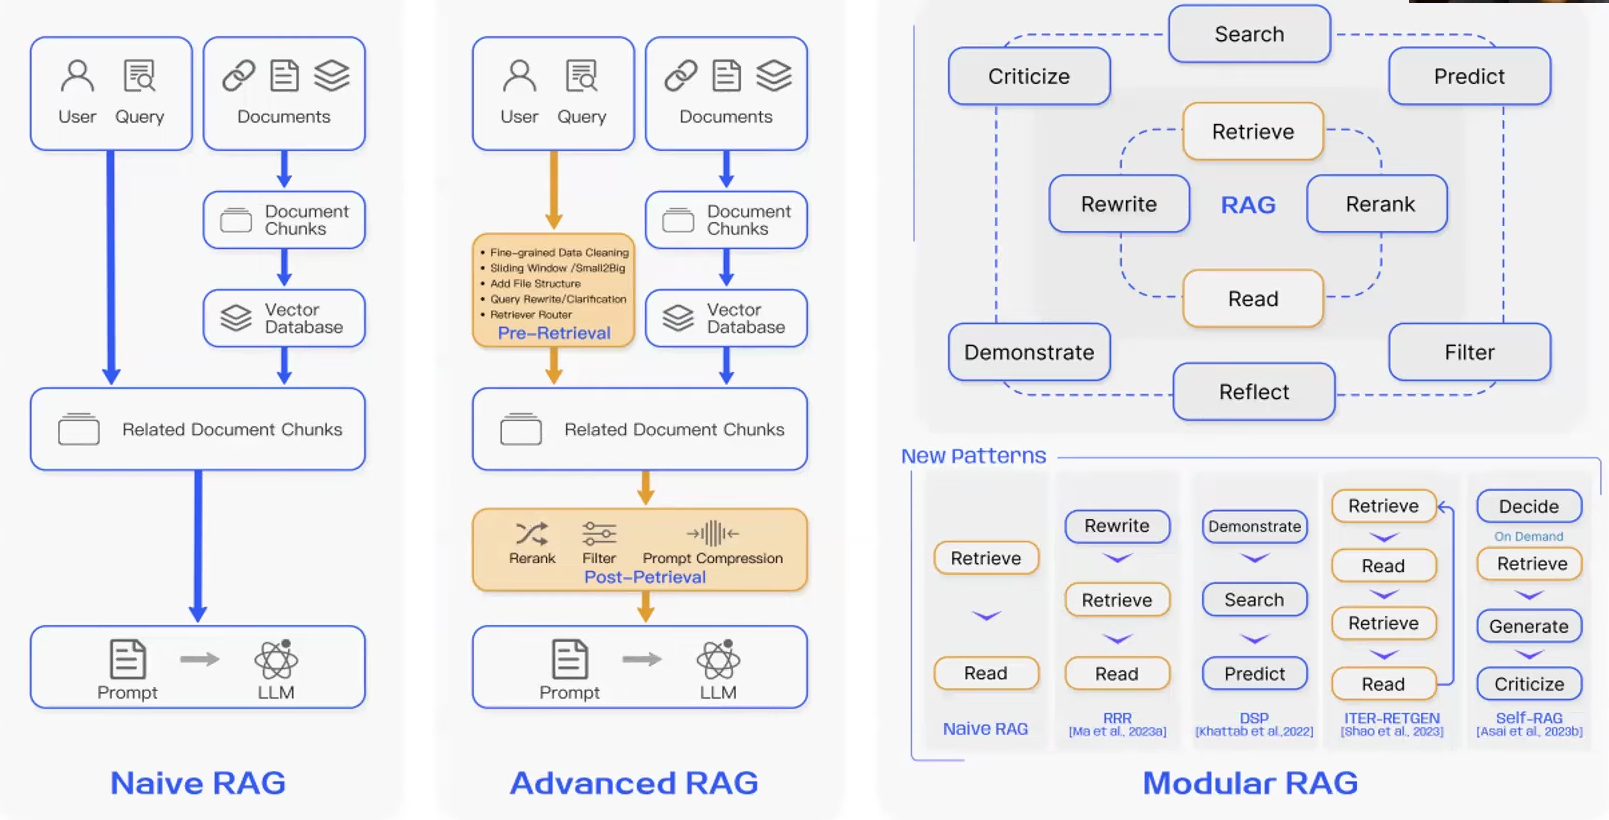

# Hybrid RAG: Reciprocal Rank Fusion Hybrid Search RAG

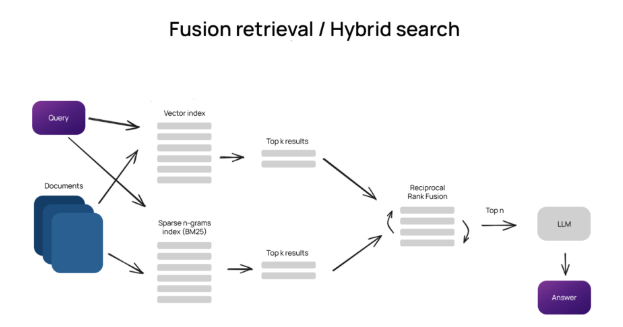

## Future Work:

1. I'm planning to enhance my search system by integrating Hybrid RAG, which combines Retrieval-Augmented Generation with Reciprocal Rank Fusion. This approach will allow me to leverage both keyword-based and semantic search capabilities, ensuring more accurate and contextually relevant results. By using Reciprocal Rank Fusion, I can merge results from different search methods, assigning scores based on rank positions to create a comprehensive and optimized ranked list.
2. I'm looking to incorporate video resources by using audio transcript similarity matching. This will involve transcribing video content and aligning it with user queries to ensure the videos are contextually relevant. By extracting timestamps from these transcripts, I can direct users to specific segments of the videos that are most pertinent to their queries. This integration will enrich the search experience by providing not only text-based resources but also precise video content that addresses user needs effectively.